# Свёрточная нейронная сеть на датасете пейзажей 6 классов.

## Загрузка данных

Импорт пакетов

In [67]:
import numpy as np
import os, shutil
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

Определение классов и меток классов

In [68]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Загрузка изображений и меток из папки датасета

In [69]:
def load_data():
    """
        - 14 034 изображения для обучения сети.
        - 3000 изображений, чтобы оценить, насколько точно сеть научилась классифицировать изображения.
    """
    
    datasets = ['C:\codeblocks\kaggle_original_data_1\seg_train\seg_train', 
                'C:\codeblocks\kaggle_original_data_1\seg_test\seg_test']
    output = []
    
    #Итерация между тренировочным и тестовым датасетами
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        #Итерация по каждой папке в датасете 
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            #Итерация по каждому изображению
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                #Получение пути изображения
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                #Открытие изображения и подгон размеров
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                #Устанавливаем соответствие изображений и меток
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

Вызываем функцию

In [70]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\codeblocks\kaggle_original_data_1\seg_train\seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:05<00:00, 457.42it/s]


Loading C:\codeblocks\kaggle_original_data_1\seg_test\seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 421.73it/s]


Перемешивание набора

In [71]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Рассмотрим набор данных

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


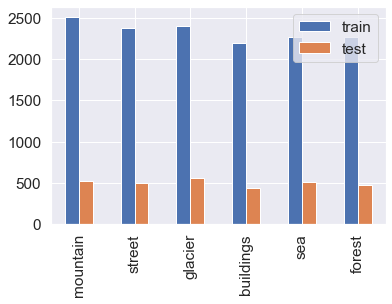

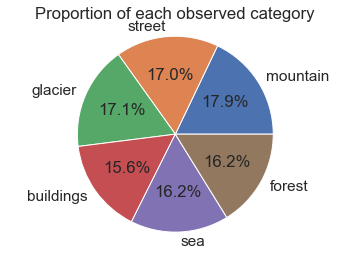

In [72]:
'''
Сколько примеров обучения и тестирования у нас есть?
Каков размер изображений?
Какова доля каждой наблюдаемой категории?'''

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Масштабирование данных

In [73]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

Отображение случайных примеров

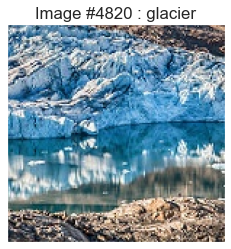

In [74]:
#Отображение случайного изображения с меткой
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
display_random_image(class_names, train_images, train_labels)

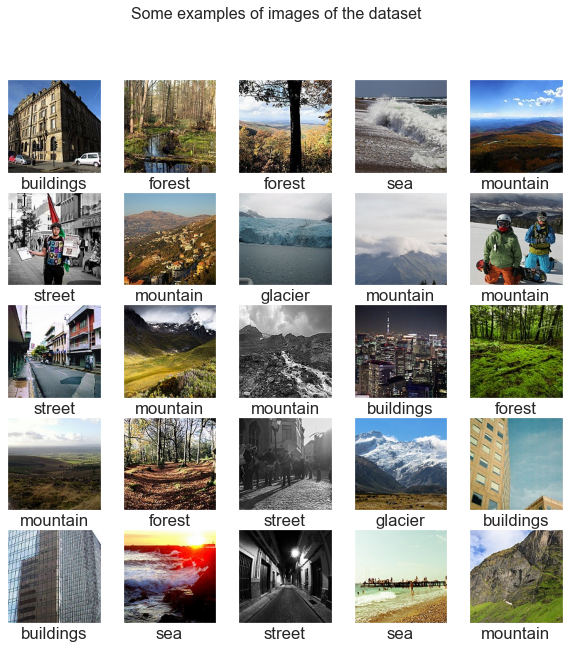

In [75]:
#Отображение 25 изображений из массива изображений с соответствующими метками
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()
display_examples(class_names, train_images, train_labels)

## Построение модели

In [76]:
#Создание небольшой сверточной нейронной сети, включающей в себя слой прореживания
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
    input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

#Настройка модели для обучения (компиляция модели)
from tensorflow import keras
from keras import optimizers
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Dropout — метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения.

Термин «dropout» (выбивание, выбрасывание) характеризует исключение определённого процента (50% в нашем случае) случайных нейронов (находящихся как в скрытых, так и видимых слоях) на разных итерациях (эпохах) во время обучения нейронной сети. Это очень эффективный способ усреднения моделей внутри нейронной сети. В результате более обученные нейроны получают в сети больший вес. Такой приём значительно увеличивает скорость обучения, качество обучения на тренировочных данных, а также повышает качество предсказаний модели на новых тестовых данных.

Оптимизатор - adam (RMSProp + Momentum). Momentum - учитывает прошлый градиент для лучшего обновления. RMSProp - экспоненциально взвешенное среднее значение квадратов прошлых градиентов.
Функция потерь: мы используем разреженную категориальную перекрестную энтропию (sparse_categorical_crossentropy) для классификации, каждое изображение принадлежит только к одному классу.

In [77]:
#Рассмотрим архитектуру сети
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 128)     

In [78]:
#Обучение модели
model_history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 142s 2s/step - loss: 1.1279 - accuracy: 0.5564 - val_loss: 0.8287 - val_accuracy: 0.6726
Epoch 2/10
88/88 [==============================] - 137s 2s/step - loss: 0.8018 - accuracy: 0.7019 - val_loss: 0.6574 - val_accuracy: 0.7531
Epoch 3/10
88/88 [==============================] - 137s 2s/step - loss: 0.6488 - accuracy: 0.7587 - val_loss: 0.7018 - val_accuracy: 0.7417
Epoch 4/10
88/88 [==============================] - 137s 2s/step - loss: 0.5625 - accuracy: 0.7894 - val_loss: 0.4916 - val_accuracy: 0.8261
Epoch 5/10
88/88 [==============================] - 135s 2s/step - loss: 0.5278 - accuracy: 0.8057 - val_loss: 0.5810 - val_accuracy: 0.7845
Epoch 6/10
88/88 [==============================] - 136s 2s/step - loss: 0.4528 - accuracy: 0.8327 - val_loss: 0.4604 - val_accuracy: 0.8304
Epoch 7/10
88/88 [==============================] - 135s 2s/step - loss: 0.4375 - accuracy: 0.8422 - val_loss: 0.5084 - val_accuracy: 0.8187
Epoch 8/10
88

## Анализ результатов

Графики точности и потерь во время обучения

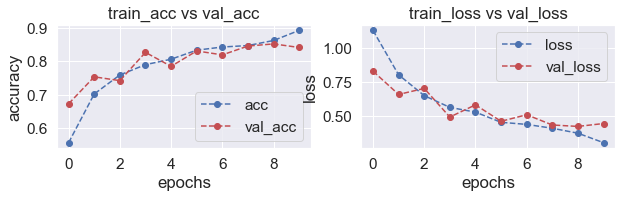

In [79]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    #График точности
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    #График потерь
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(model_history)

Проверка производительности на тестовом наборе

In [80]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 7s 75ms/step - loss: 0.4327 - accuracy: 0.8603


Достигнута точность 0.86

Давайте посмотрим, как работает классификатор на случайных изображениях

94/94 [==============================] - 7s 74ms/step


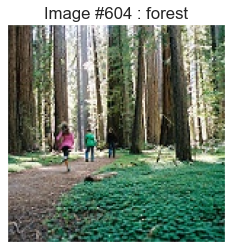

In [81]:
predictions = model.predict(test_images)     #Вектор вероятностей
pred_labels = np.argmax(predictions, axis = 1) #Мы берем самую высокую вероятность

display_random_image(class_names, test_images, pred_labels)

## Анализ ошибок

Вывод 25 примеров изображений с неправильной маркировкой

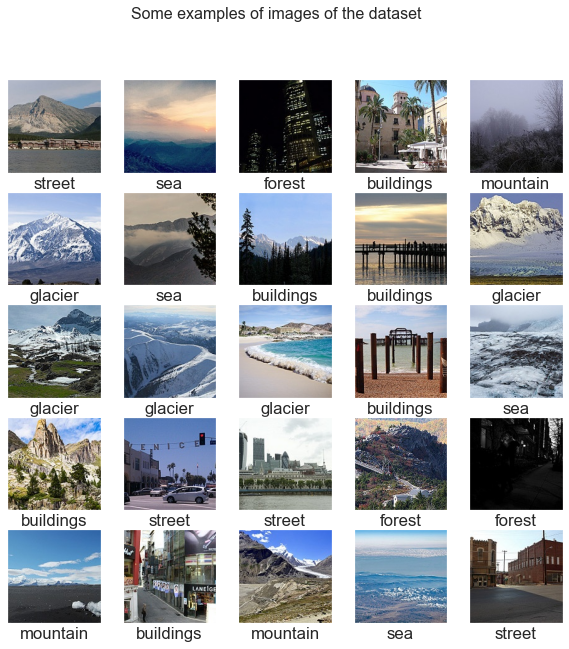

In [82]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Матрица неточностей:

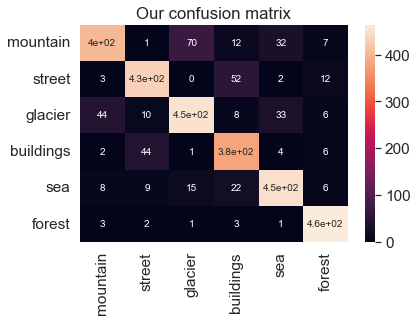

In [84]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Our confusion matrix')
plt.show()

Вывод: У классификатора иногда возникают трудности с улицами и зданиями. 
Что ж, это можно понять, поскольку на улице есть здания. 
У него также есть проблемы с морем, ледником и горами. 
Даже человеку трудно полностью различить их. 

# Использование VGG-16

## Извлечение компонентов  VGG-16

In [85]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

model_vgg = VGG16(weights='imagenet', include_top=False)
model_vgg = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-5].output)

In [86]:
train_features = model_vgg.predict(train_images)
test_features = model_vgg.predict(test_images)

94/94 [==============================] - 78s 810ms/step


In [87]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [88]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

new_model = Model(layer_input, x)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
new_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_15 (Conv2D)          (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 64)         0   

In [90]:
vgg_history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 140s 2s/step - loss: 0.7298 - accuracy: 0.7251 - val_loss: 0.3666 - val_accuracy: 0.8685
Epoch 2/10
88/88 [==============================] - 139s 2s/step - loss: 0.3233 - accuracy: 0.8838 - val_loss: 0.2933 - val_accuracy: 0.8963
Epoch 3/10
88/88 [==============================] - 133s 2s/step - loss: 0.2538 - accuracy: 0.9124 - val_loss: 0.3090 - val_accuracy: 0.8899
Epoch 4/10
88/88 [==============================] - 130s 1s/step - loss: 0.2172 - accuracy: 0.9211 - val_loss: 0.3100 - val_accuracy: 0.8945
Epoch 5/10
88/88 [==============================] - 133s 2s/step - loss: 0.1811 - accuracy: 0.9348 - val_loss: 0.2789 - val_accuracy: 0.9017
Epoch 6/10
88/88 [==============================] - 134s 2s/step - loss: 0.1620 - accuracy: 0.9419 - val_loss: 0.2900 - val_accuracy: 0.9127
Epoch 7/10
88/88 [==============================] - 134s 2s/step - loss: 0.1272 - accuracy: 0.9548 - val_loss: 0.2728 - val_accuracy: 0.9056
Epoch 8/10
88

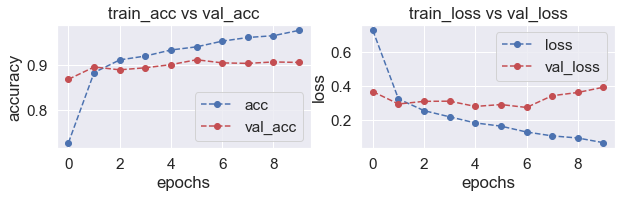

In [91]:
def plot_accuracy_loss(history):
    """
        Графики точности и потерь во время обучения
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(vgg_history)

94/94 [==============================] - 10s 102ms/step
Accuracy : 0.8963333333333333


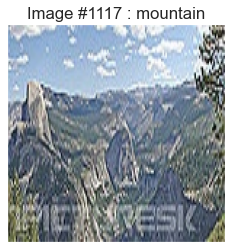

In [92]:
#Производительность модели на тестовом наборе
#Достигнута точность 0.90
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))
display_random_image(class_names, test_images, pred_labels)

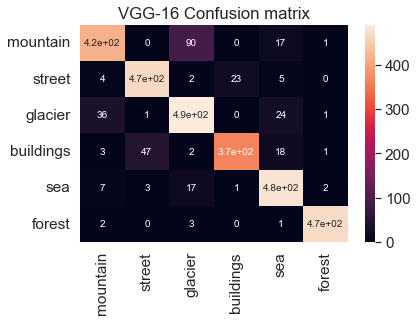

In [93]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('VGG-16 Confusion matrix')
plt.show()

#  Визуализация знаний, заключенных в сверточной нейронной сети

## Визуализация промежуточных активаций

Выберем входное изображение, не являющееся частью обучающего набора.

(1, 150, 150, 3)


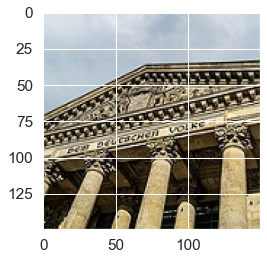

In [94]:
'''Предварительная обработка единственного изображения - 
преобразование его в четырехмерный тензор'''

img_path = 'C:\codeblocks\kaggle_original_data_1\seg_pred\seg_pred/1793.jpg'
from keras.preprocessing import image
import numpy as np
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Его форма (1, 150, 150, 3)
print(img_tensor.shape)

#Отображение тестового изображения
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

Создание экземпляра модели из входного тензора и списка выходных тензоров

In [95]:
from keras import models

#Извлечение вывода верхних восьми слоев
layer_outputs = [layer.output for layer in model.layers[:8]]

#Создание модели, которая вернет эти выводы с учетом заданного входа
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

#Запуск модели в режиме прогнозирования
activations = activation_model.predict(img_tensor) 
#Вернет список с пятью массивами Numpy: по одному на каждую активацию слоя

1/1 [==============================] - 0s 210ms/step


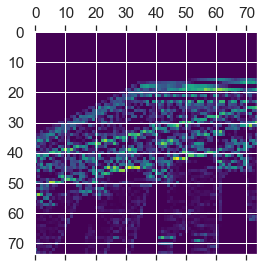

In [96]:
import matplotlib.pyplot as plt
first_layer_activation = activations[1]
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

Визуализация всех каналов для всех промежуточных активаций

C:\Users\markc\AppData\Local\Temp\ipykernel_17768\2588350540.py:27: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


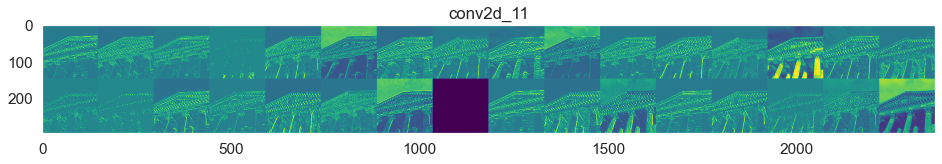

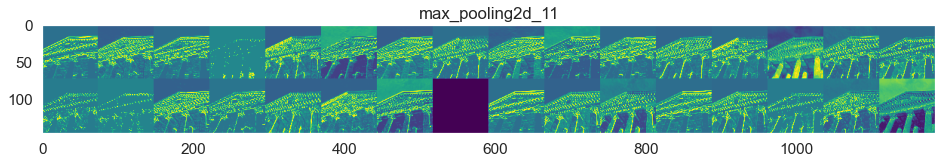

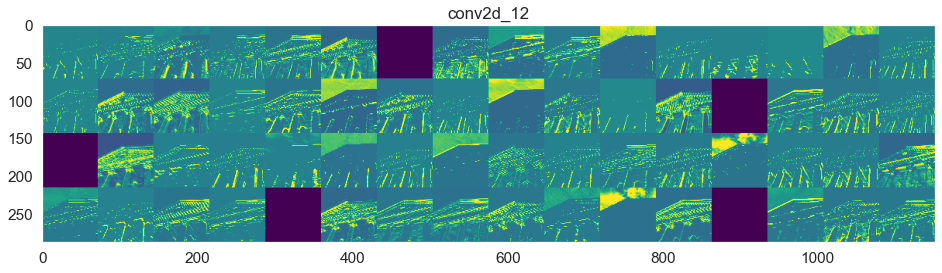

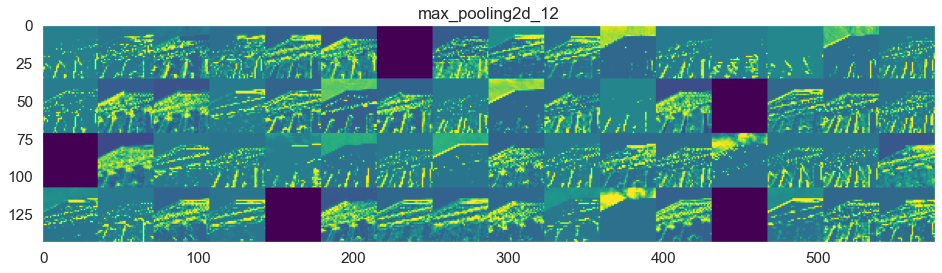

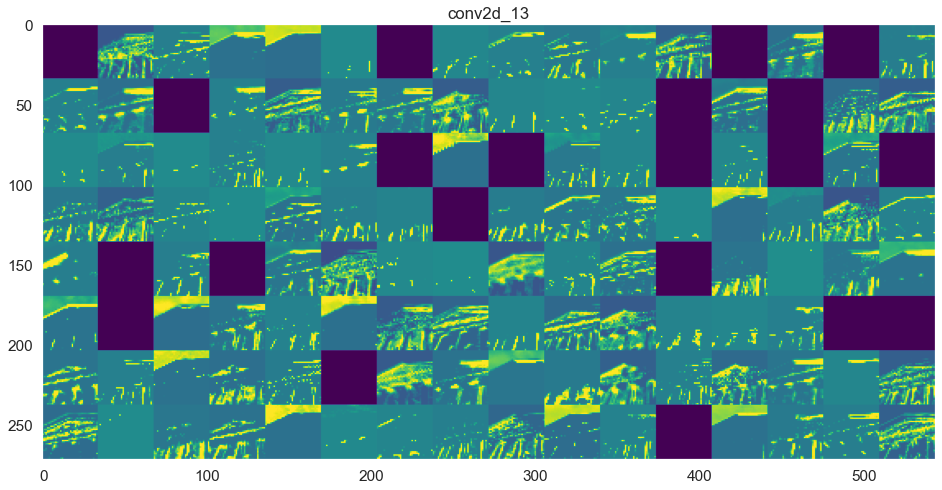

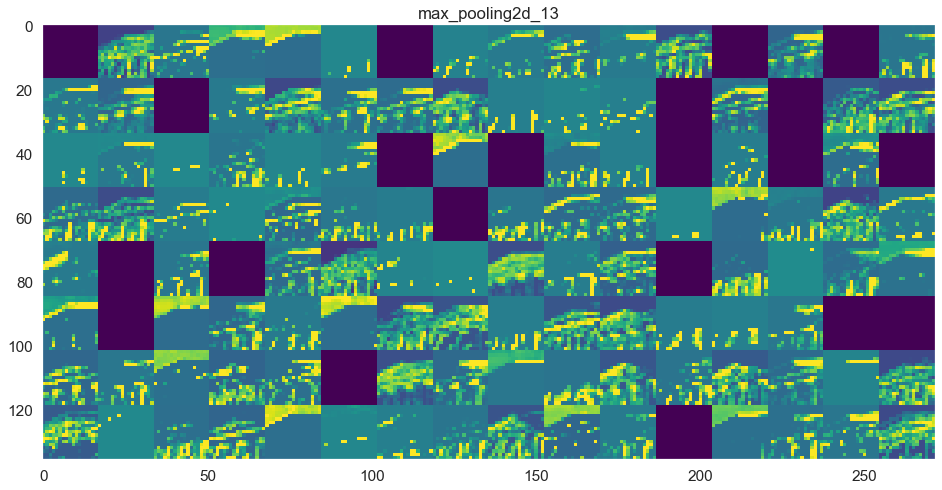

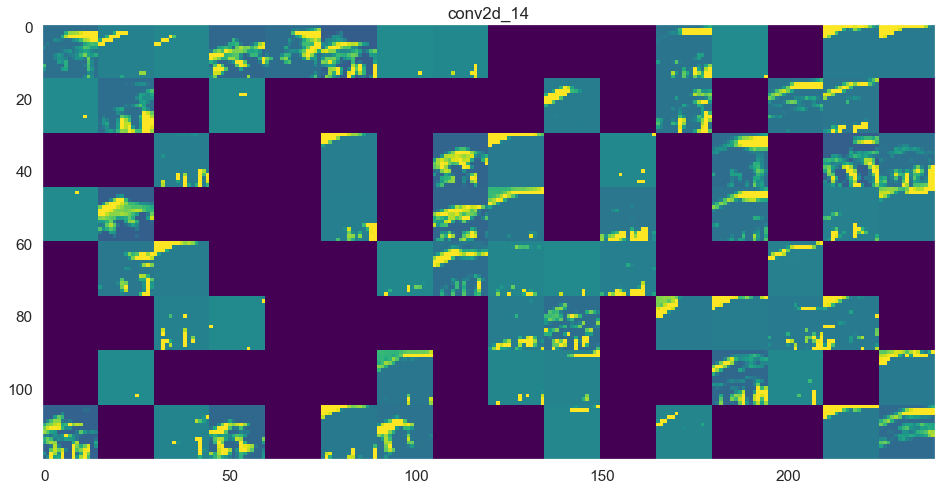

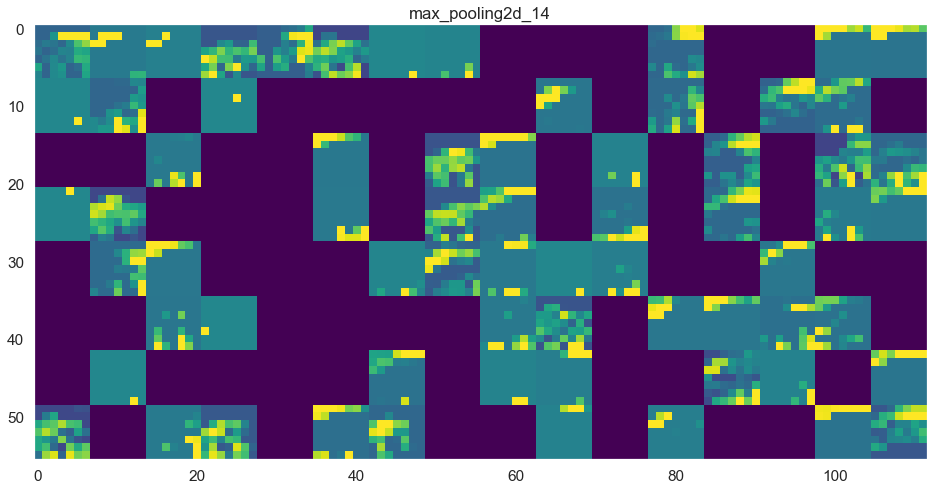

In [97]:
#Извлечь имена слоев для отображения на рисунке 
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
#Цикл отображения карт признаков
for layer_name, layer_activation in zip(layer_names, activations):
    #Количество признаков в карте признаков 
    n_features = layer_activation.shape[-1]
        
    #Карта признаков имеет форму (1, size, size, n_features)
    size = layer_activation.shape[1]

    #Количество колонок в матрице отображения каналов
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    #Вывод каждого фильтра в большую горизонтальную сетку
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,
                                          col * images_per_row + row]
            '''Заключительная обработка признака, 
            чтобы получить приемлемую визуализацию'''
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            #Вывод сетки
            display_grid[col * size : (col + 1) * size,
                      row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                         scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

По мере подъема вверх по слоям активации становятся все более абстрактными, а их визуальная интерпретация все более сложной. Они начинают кодировать высокоуровневые понятия, такие как «колонны» или «фронтон». Высокоуровневые представления несут все меньше информации об исходном изображении и все больше — о классе изображения.

Разреженность активаций увеличивается с глубиной слоя: в первом слое все
фильтры активируются исходным изображением, но в последующих слоях все
больше и больше остается пустых фильтров. Это означает, что шаблон, соответствующий фильтру, не обнаруживается в исходном изображении.

Мы только что рассмотрели важную универсальную характеристику представлений, создаваемых глубокими нейронными сетями: признаки, извлекаемые слоями, становятся все более абстрактными с глубиной слоя. Активации на верхних слоях содержат все меньше и меньше информации о конкретном входном изображении и все больше и больше о цели (в данном случае о классе изображения — кошка или собака). Глубокая нейронная сеть фактически действует как конвейер очистки информации, который получает неочищенные исходные данные (в данном случае изображения в формате RGB) и подвергает их многократным преобразованиям, фильтруя ненужную информацию (например, конкретный внешний вид изображения) и оставляя и очищая нужную (например, класс изображения). 

Примерно так же люди и животные воспринимают окружающий мир: понаблюдав сцену в течение нескольких секунд, человек запоминает, какие абстрактные объекты присутствуют в ней (велосипед, дерево), но не запоминает всех деталей внешнего вида этих объектов. Фактически при попытке нарисовать велосипед по памяти, скорее всего, вам не удастся получить более или менее правильное изображение, даже при том, что вы могли видеть велосипеды тысячи раз. Ваш мозг научился полностью абстрагировать видимую картинку, получаемую на входе, и преобразовывать ее в высокоуровневые визуальные понятия, фильтруя при этом неважные визуальные детали и затрудняя тем самым их запоминание.